In [2]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax, random, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, MCMC, NUTS

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 果物の収穫量に関するデータ

そのまま扱うと分散が過剰になるデータを個体差を考慮したポアソン分布によってモデル化する。

In [3]:
data = pd.DataFrame({
    
    'num_fruits':[445, 378, 383, 406, 458, 433, 568, 521, 446, 437, 327, 508, 342,
       385, 363, 495, 347, 419, 380, 582]
})

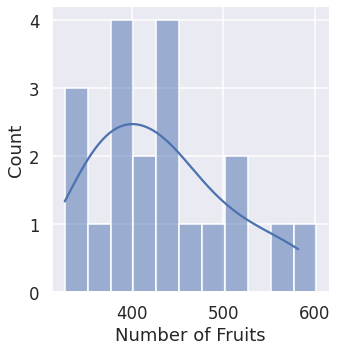

In [4]:
sns.displot(data=data, x='num_fruits', kde=True, binwidth=25);

plt.xlabel('Number of Fruits');

In [5]:
print('平均：{:.2f}'.format(data['num_fruits'].mean()))
print('分散：{:.2f}'.format(data['num_fruits'].var()))

平均：431.15
分散：5363.19


## モデル化

In [6]:
y = data['num_fruits'].values

num_trees = len(y)

In [7]:
def model(y=None, num_data=0):
    b = numpyro.sample('b', dist.Normal(9, 10))

    s = numpyro.sample('s', dist.HalfCauchy(5))
    r = numpyro.sample('r', dist.Normal(0, s), sample_shape=(num_trees,))
    
    theta = numpyro.deterministic('theta', b + r)
    
    mu = numpyro.deterministic('mu', jax.numpy.exp(theta))
        
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(mu), obs=y)

nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), y=y, num_data=len(y))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 3500/3500 [00:00<00:00, 5135.10it/s, 15 steps of size 2.09e-01. acc. prob=0.93]


In [8]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

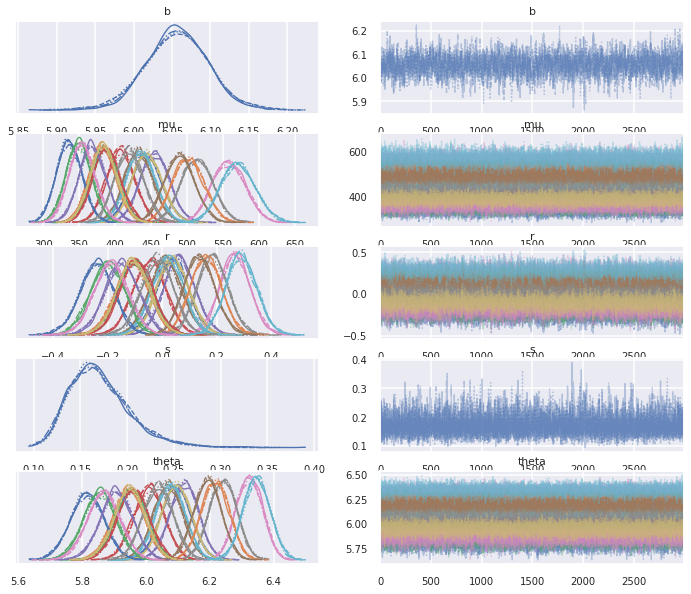

In [9]:
az.plot_trace(idata);

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,6.056,0.041,5.981,6.135,0.001,0.001,1591.0,2354.0,1.0
mu[0],443.565,20.932,404.768,483.707,0.129,0.092,26346.0,8227.0,1.0
mu[1],382.266,18.654,346.547,416.505,0.117,0.083,25248.0,8585.0,1.0
mu[2],386.576,19.084,351.370,422.353,0.121,0.086,25094.0,8805.0,1.0
mu[3],407.799,19.584,370.913,444.456,0.120,0.085,26509.0,8990.0,1.0
...,...,...,...,...,...,...,...,...,...
theta[15],6.193,0.043,6.114,6.273,0.000,0.000,21205.0,8784.0,1.0
theta[16],5.868,0.051,5.772,5.963,0.000,0.000,22207.0,8743.0,1.0
theta[17],6.038,0.046,5.951,6.123,0.000,0.000,24879.0,8683.0,1.0
theta[18],5.950,0.048,5.860,6.040,0.000,0.000,26142.0,9190.0,1.0


## 事後予測チェック

In [11]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), num_data=len(y))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

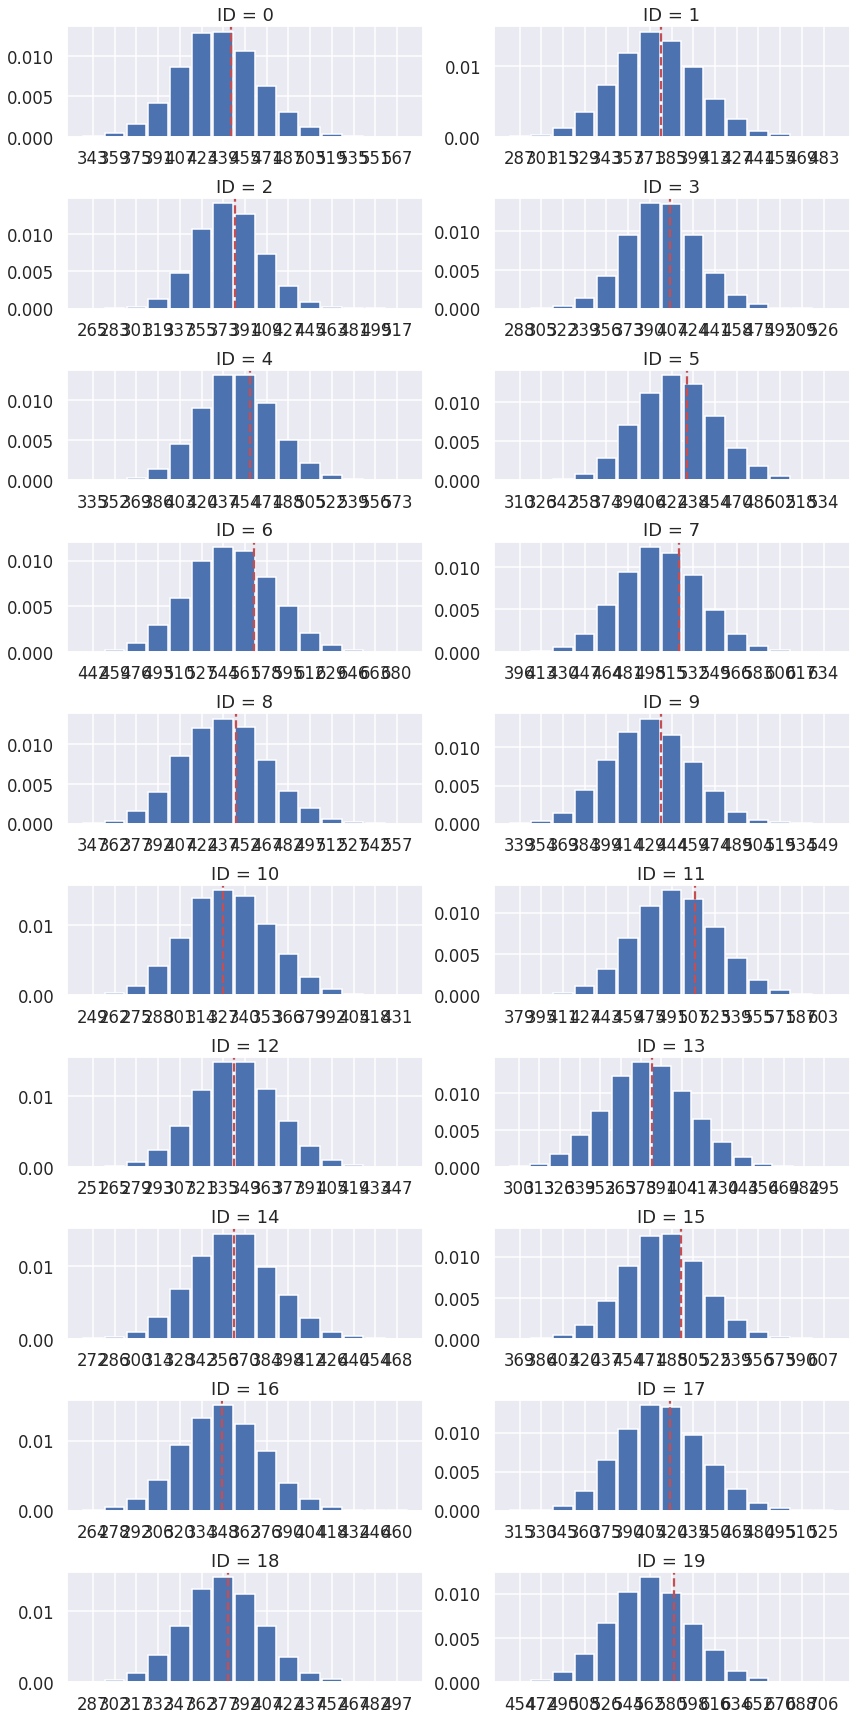

In [15]:
fig = plt.figure(figsize=(12, 24))

for k in range(20):
    
    ax = fig.add_subplot(10, 2, k+1)
    
    az.plot_dist(ppc_samples['obs'][:, k])
    ax.axvline(y[k], color='r', linestyle='dashed')
    ax.set_title('ID = {}'.format(k))

plt.tight_layout()

## ランダム効果の確認

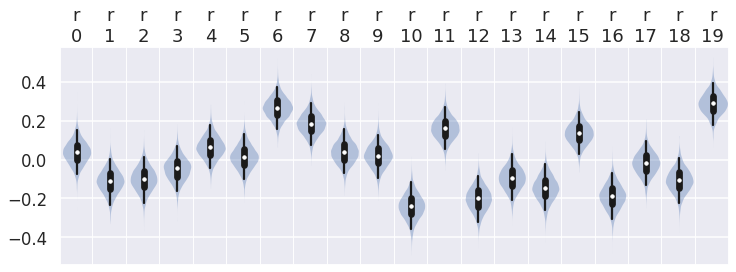

In [21]:
az.plot_violin(idata.posterior["r"], grid=(1, num_trees), figsize=(12,4));

## 新しい特徴量の確認

spanというのは木の成長度合いを表す新規特徴量。以下ではspanとランダム効果に相関が見られることを確認している。

In [23]:
data_updated = pd.DataFrame({
    'num_fruits':[445, 378, 383, 406, 458, 433, 568, 521, 446, 437, 327, 508, 342, 385, 363, 495, 347, 419, 380, 582],
    'span':[4.5, 3.8, 3.7, 4.2, 4.5, 4.1, 4.2, 4.5, 3.9, 4. , 3.2, 3.9, 3. , 4.1, 3.7, 4.9, 4.3, 4. , 3.1, 4.8]
})

span = data_updated['span']

In [24]:
r_mean = mcmc_samples['r'].mean(axis=0)

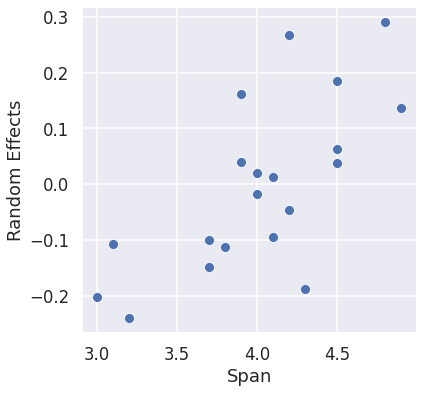

In [25]:
fig = plt.figure(figsize=(6, 6))

sns.scatterplot(x=span, y=r_mean, s=100)

plt.xlabel('Span')
plt.ylabel('Random Effects');

## 特徴量を利用した回帰

In [27]:
x = data_updated["span"].values

x_mu = np.mean(x)
x_sd = np.std(x)

x_scaled = (x - x_mu) / x_sd

In [30]:
def model(x_scaled=None, y=None, num_data=0):
    
    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10))
    
    s = numpyro.sample('s', dist.HalfCauchy(5))
    r = numpyro.sample('r', dist.Normal(0, s), sample_shape=(num_trees,))
    
    theta = a * x_scaled + b + r
    
    mu = numpyro.deterministic("mu", jax.numpy.exp(theta))
    
    with numpyro.plate('data', num_data):
        
        numpyro.sample('obs', dist.Poisson(mu), obs=y)

nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), x_scaled=x_scaled, y=y, num_data=len(y))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 3500/3500 [00:00<00:00, 6170.86it/s, 7 steps of size 3.34e-01. acc. prob=0.89] 


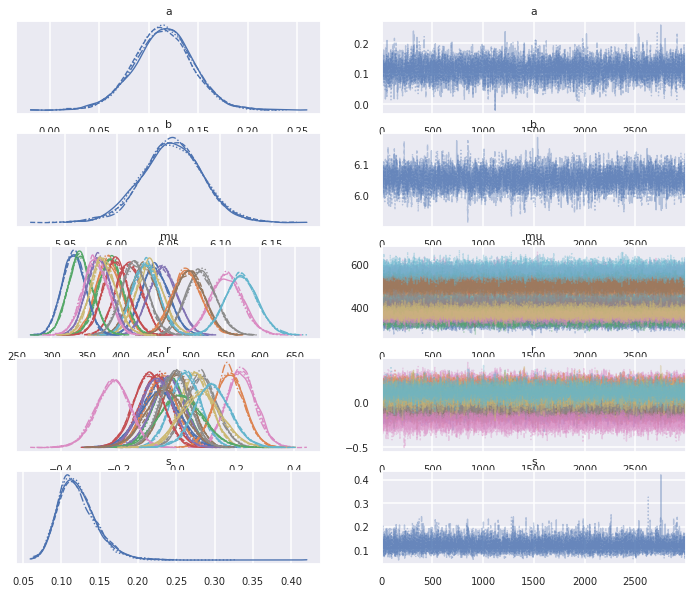

In [31]:
az.plot_trace(idata);

In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.115,0.030,0.059,0.172,0.000,0.000,4883.0,5833.0,1.0
b,6.054,0.030,5.996,6.108,0.000,0.000,3940.0,5564.0,1.0
mu[0],448.998,20.036,412.452,487.661,0.147,0.104,18583.0,7712.0,1.0
mu[1],382.449,18.046,348.503,417.010,0.129,0.092,19366.0,9480.0,1.0
mu[2],385.164,18.354,350.474,419.754,0.130,0.092,19918.0,9099.0,1.0
mu[3],411.416,18.758,375.821,445.824,0.138,0.097,18425.0,9501.0,1.0
mu[4],460.309,20.303,423.165,498.723,0.150,0.106,18413.0,9657.0,1.0
mu[5],433.214,19.492,397.826,471.030,0.134,0.095,20990.0,8089.0,1.0
mu[6],551.523,22.853,509.330,595.495,0.178,0.126,16528.0,9512.0,1.0
mu[7],514.766,21.400,473.312,553.959,0.154,0.109,19214.0,9051.0,1.0


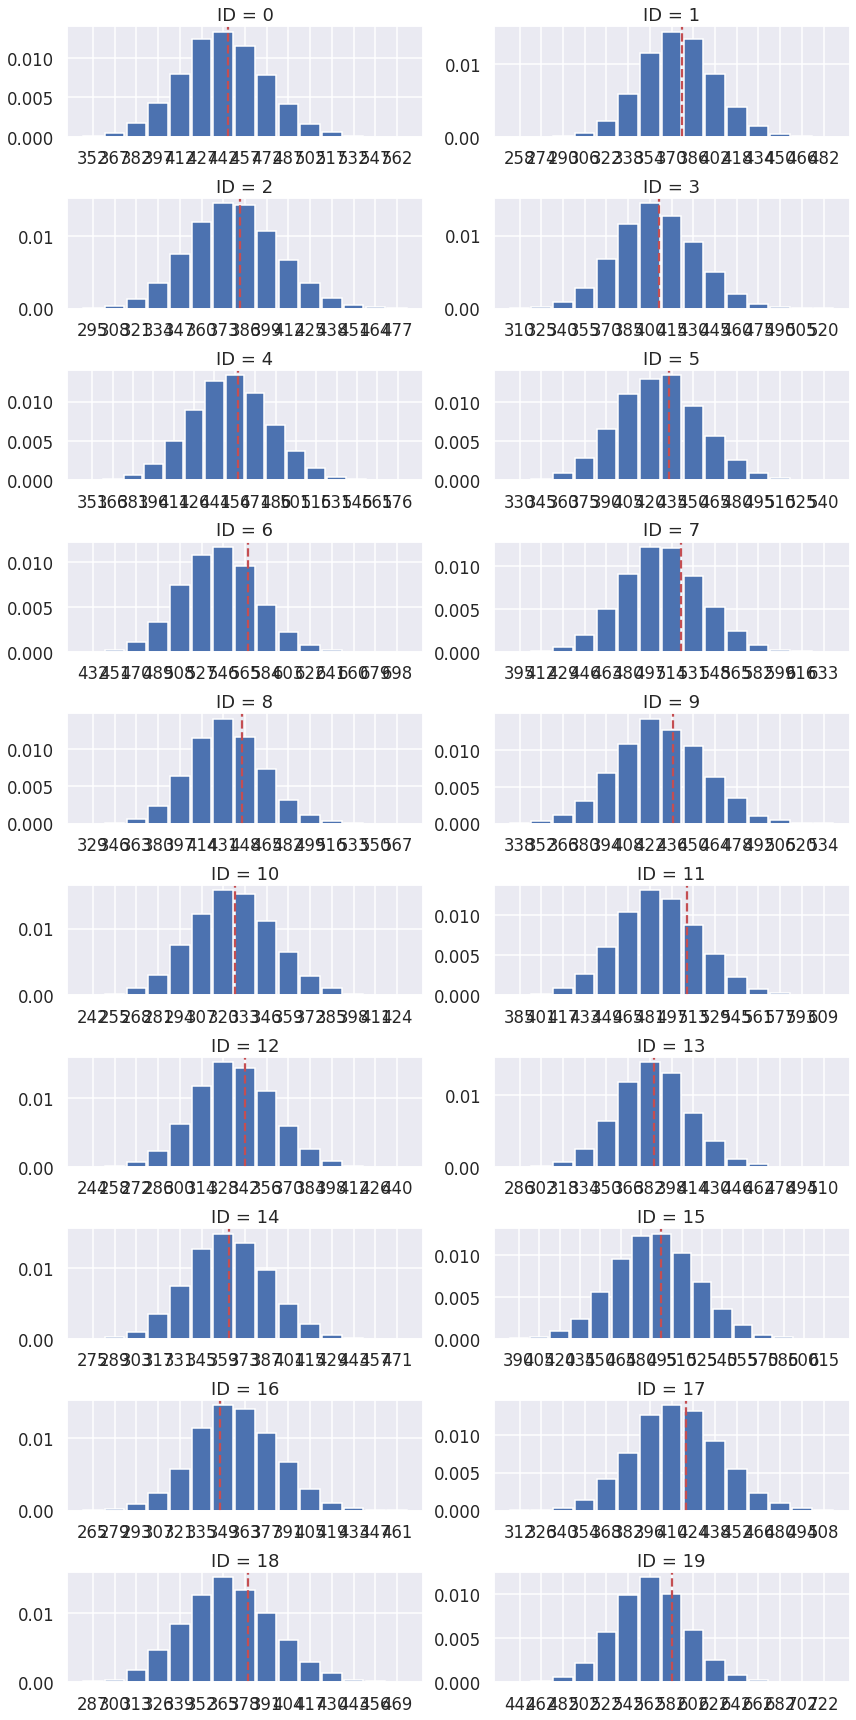

In [33]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), x_scaled=x_scaled, num_data=len(x_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

fig = plt.figure(figsize=(12, 24))

for k in range(20):
    
    ax = fig.add_subplot(10, 2, k+1)
    
    az.plot_dist(ppc_samples['obs'][:, k])
    ax.axvline(y[k], color='r', linestyle='dashed')
    ax.set_title('ID = {}'.format(k))

plt.tight_layout()

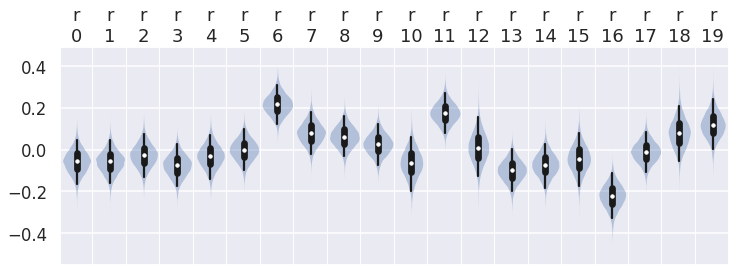

In [34]:
az.plot_violin(idata.posterior['r'], grid=(1, num_trees), figsize=(12, 4));

## 真値と比較する

In [35]:
r_true = np.array([ 0., 0.05, 0., -0.03, 0.07, 0.03, 0.26, 0.17, 0.06, 0.03, 0.02,
                   0.2, -0.06, -0.05, -0.07, 0.08, -0.15, 0.05, 0.03, 0.18])
r_mean = mcmc_samples['r'].mean(axis=0)

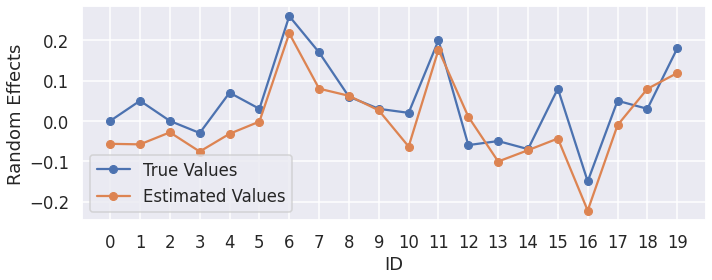

In [36]:
fig = plt.figure(figsize=(10, 4))

plt.plot(np.arange(num_trees), r_true, 'o-', markersize=8, label='True Values')
plt.plot(r_mean, 'o-', markersize=8, label='Estimated Values')
plt.xticks(np.arange(num_trees))
plt.xlabel('ID')
plt.ylabel('Random Effects')
plt.legend()

plt.tight_layout()

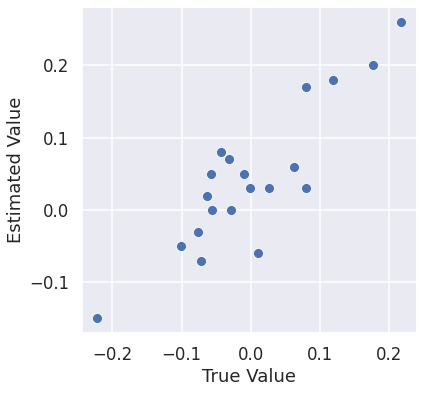

In [37]:
fig = plt.figure(figsize=(6, 6))

sns.scatterplot(x=r_mean, y=r_true, s=100)

plt.xlabel('True Value')
plt.ylabel('Estimated Value');